<a href="https://colab.research.google.com/github/wlg100/numseqcont_circuit_expms/blob/main/notebook_templates/minimal_circuit_template.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

# Setup
(No need to change anything)

In [1]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    # Install another version of node that makes PySvelte work way faster
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-ooxq5ssa
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-ooxq5ssa
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 218ebd6f491f47f5e2f64e4c4327548b60a093eb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━


## Installing the NodeSource Node.js 16.x repo...


## Populating apt-get cache...

+ apt-get update
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:6 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:8 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:9 http://archive.ubuntu.com/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_6

In [2]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio

if IN_COLAB or not DEBUG_MODE:
    # Thanks to annoying rendering issues, Plotly graphics will either show up in colab OR Vscode depending on the renderer - this is bad for developing demos! Thus creating a debug mode.
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "png"

In [3]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [4]:
import pysvelte

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [5]:
torch.set_grad_enabled(False)

Plotting helper functions:

In [6]:
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

# Load Model

Decide which model to use (eg. gpt2-small vs -medium)

In [7]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


# Import functions from repo

In [8]:
!git clone https://github.com/callummcdougall/ARENA_2.0.git

Cloning into 'ARENA_2.0'...
remote: Enumerating objects: 7955, done.
remote: Counting objects: 100% (1687/1687), done.
remote: Compressing objects: 100% (238/238), done.
remote: Total 7955 (delta 1529), reused 1549 (delta 1444), pack-reused 6268
Receiving objects: 100% (7955/7955), 129.76 MiB | 21.44 MiB/s, done.
Resolving deltas: 100% (4700/4700), done.


In [9]:
cd ARENA_2.0/chapter1_transformers/exercises/part3_indirect_object_identification

/content/ARENA_2.0/chapter1_transformers/exercises/part3_indirect_object_identification


In [10]:
import ioi_circuit_extraction as ioi_circuit_extraction

# Generate dataset with multiple prompts

In [11]:
class Dataset:
    def __init__(self, prompts, tokenizer, S1_is_first=False):
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.prompts
            ]
        )
        # all_ids = [prompt["TEMPLATE_IDX"] for prompt in self.ioi_prompts]
        all_ids = [0 for prompt in self.prompts] # only 1 template
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        texts = [ prompt["text"] for prompt in self.prompts ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )
        self.io_tokenIDs = [
            self.tokenizer.encode(" " + prompt["S5"])[0] for prompt in self.prompts
        ]
        self.s_tokenIDs = [
            self.tokenizer.encode(" " + prompt["S4"])[0] for prompt in self.prompts
        ]

        # word_idx: for every prompt, find the token index of each target token and "end"
        # word_idx is a tensor with an element for each prompt. The element is the targ token's ind at that prompt
        self.word_idx = {}
        for targ in [key for key in self.prompts[0].keys() if (key != 'text' and key != 'S5')]:
            targ_lst = []
            for prompt in self.prompts:
                input_text = prompt["text"]
                tokens = model.tokenizer.tokenize(input_text)
                if S1_is_first and targ == "S1":  # only use this if first token doesn't have space Ġ in front
                    target_token = prompt[targ]
                else:
                    target_token = "Ġ" + prompt[targ]
                target_index = tokens.index(target_token)
                targ_lst.append(target_index)
            self.word_idx[targ] = torch.tensor(targ_lst)

        targ_lst = []
        for prompt in self.prompts:
            input_text = prompt["text"]
            tokens = self.tokenizer.tokenize(input_text)
            end_token_index = len(tokens) - 1
            targ_lst.append(end_token_index)
        self.word_idx["end"] = torch.tensor(targ_lst)

    def __len__(self):
        return self.N

Repalce io_tokens with correct answer (next, which is '5') and s_tokens with incorrect (current, which repeats)

In [43]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'S1': str(i),
            'S2': str(i+1),
            'S3': str(i+2),
            'S4': str(i+3),
            'S5': str(i+4),
            'text': f"{i} {i+1} {i+2} {i+3}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(1, 11)
prompts_list_2 = generate_prompts_list(11, 21)

In [44]:
len(prompts_list)

10

In [45]:
len(prompts_list_2)

10

In [46]:
# template = "[S1] [S2] [S3] [S4]"
# prompts_list = [{'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'S5': '5', 'text': '1 2 3 4'}]

dataset = Dataset(prompts_list, model.tokenizer, S1_is_first=True)

In [47]:
# template = "[S1] [S2] [S3] [S4]"
# prompts_list = [{'S1': '1', 'S2': '1', 'S3': '1', 'S4': '1', 'S5': '1', 'text': '1 1 1 1'}]

dataset_2 = Dataset(prompts_list_2, model.tokenizer, S1_is_first=True)

# Ablate the model and compare with original

In [ ]:
# from ioi_dataset import NAMES, IOIDataset

# N = 25
# ioi_dataset = IOIDataset(
#     prompt_type="mixed",
#     N=N,
#     tokenizer=model.tokenizer,
#     prepend_bos=False,
#     seed=1,
#     # device=str(device)
# )
# abc_dataset = ioi_dataset.gen_flipped_prompts("ABB->XYZ, BAB->XYZ")

In [20]:
from torch import Tensor

def logits_to_ave_logit_diff_2(logits: Float[Tensor, "batch seq d_vocab"], dataset: Dataset, per_prompt=False):
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''

    # Only the final logits are relevant for the answer
    # Get the logits corresponding to the indirect object / subject tokens respectively
    io_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset.word_idx["end"], dataset.io_tokenIDs]
    s_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset.word_idx["end"], dataset.s_tokenIDs]
    # Find logit difference
    answer_logit_diff = io_logits - s_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()

## Test with every head intact

(sanity check to ensure ablation and means_dataset done right)

In [48]:
pairs = [(x, y) for x in range(12) for y in range(12)]

CIRCUIT = {
    "number mover": pairs,
    "number mover 4": pairs,
    "number mover 3": pairs,
    "number mover 2": pairs,
    "number mover 1": pairs,
    # "name mover": [(9, 9), (10, 0), (9, 6)],
    # "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    # "negative name mover": [(10, 7), (11, 10)],
    # "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    # "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    # "duplicate token": [(0, 1), (0, 10), (3, 0)],
    # "previous token": [(2, 2), (4, 11)],
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
    # "name mover": "end",
    # "backup name mover": "end",
    # "negative name mover": "end",
    # "s2 inhibition": "end",
    # "induction": "S2",
    # "duplicate token": "S2",
    # "previous token": "S1+1",
}

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Average logit difference (IOI dataset, using entire model): 4.6237
Average logit difference (IOI dataset, only using circuit): 4.6237


This is good; we used the same dataset, but just its mean, and we get close logits after telling the function to keep every head

## Test with original name mover circuit (sanity check)

In [50]:
CIRCUIT = {
    # "number mover": [(9, 1)],
    "name mover": [(9, 9), (10, 0), (9, 6)],
    "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    "negative name mover": [(10, 7), (11, 10)],
    "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    # "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    # "duplicate token": [(0, 1), (0, 10), (3, 0)],
    # "previous token": [(2, 2), (4, 11)],
}

SEQ_POS_TO_KEEP = {
    # "number mover": "end",
    "name mover": "end",
    "backup name mover": "end",
    "negative name mover": "end",
    "s2 inhibition": "end",
    # "induction": "S2",
    # "duplicate token": "S2",
    # "previous token": "S1+1",
}

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Average logit difference (IOI dataset, using entire model): 4.6237
Average logit difference (IOI dataset, only using circuit): 0.6729


Good; as expected, it should be low, as that circuit has nothing to do with ours. This ensures we're not just getting high scores for anything.

## Test with only one head

In [51]:
CIRCUIT = {
    "number mover": [(9, 1)],
    "number mover 4": [(9, 1)],
    "number mover 3": [(9, 1)],
    "number mover 2": [(9, 1)],
    "number mover 1": [(9, 1)],
    # "name mover": [(9, 9), (10, 0), (9, 6)],
    # "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    # "negative name mover": [(10, 7), (11, 10)],
    # "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    # "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    # "duplicate token": [(0, 1), (0, 10), (3, 0)],
    # "previous token": [(2, 2), (4, 11)],
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
    # "name mover": "end",
    # "backup name mover": "end",
    # "negative name mover": "end",
    # "s2 inhibition": "end",
    # "induction": "S2",
    # "duplicate token": "S2",
    # "previous token": "S1+1",
}

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Average logit difference (IOI dataset, using entire model): 4.6237
Average logit difference (IOI dataset, only using circuit): 1.5308


## Get rid of the entire layers 10 and 11

In [52]:
pairs = [(x, y) for x in range(10) for y in range(10)]

CIRCUIT = {
    "number mover": pairs,
    "number mover 4": pairs,
    "number mover 3": pairs,
    "number mover 2": pairs,
    "number mover 1": pairs,
    # "name mover": [(9, 9), (10, 0), (9, 6)],
    # "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    # "negative name mover": [(10, 7), (11, 10)],
    # "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    # "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    # "duplicate token": [(0, 1), (0, 10), (3, 0)],
    # "previous token": [(2, 2), (4, 11)],
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
    # "name mover": "end",
    # "backup name mover": "end",
    # "negative name mover": "end",
    # "s2 inhibition": "end",
    # "induction": "S2",
    # "duplicate token": "S2",
    # "previous token": "S1+1",
}

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Average logit difference (IOI dataset, using entire model): 4.6237
Average logit difference (IOI dataset, only using circuit): 2.2351


This is great; they're very close! As expected from logit lens (where the answer appeared at L9)

## Test with top 10 heads from actv patching

Top 10, regardless of pos or neg

In [54]:
CIRCUIT = {
    "number mover": [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (10,7)],
    "number mover 4": [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (10,7)],
    "number mover 3": [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (10,7)],
    "number mover 2": [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (10,7)],
    "number mover 1": [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (10,7)],
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
}

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Average logit difference (IOI dataset, using entire model): 4.6237
Average logit difference (IOI dataset, only using circuit): 2.7761


That's likely part of a circuit.

# the top 10 positive

In [56]:
heads = [(9, 1), (7, 10), (10, 7), (8, 8), (0, 1), (8, 11), (6, 1), (0, 5), (9, 9), (11, 10)]

CIRCUIT = {
    "number mover": heads,
    "number mover 4": heads,
    "number mover 3": heads,
    "number mover 2": heads,
    "number mover 1": heads,
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
}


model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")


Average logit difference (IOI dataset, using entire model): 4.6237
Average logit difference (IOI dataset, only using circuit): 3.0229


# Compare circuit score with random subgraphs' scores

In [57]:
import random

def generate_random_pairs():
    pairs = []
    for _ in range(12):
        x = random.randint(0, 11)
        y = random.randint(0, 11)
        pairs.append((x, y))
    return pairs

random_pairs = generate_random_pairs()
print(random_pairs)

[(1, 6), (11, 5), (2, 10), (10, 2), (4, 6), (1, 7), (5, 2), (5, 11), (8, 5), (11, 10), (2, 11), (0, 10)]


In [58]:
CIRCUIT = {
    "number mover": random_pairs,
    "number mover 4": random_pairs,
    "number mover 3": random_pairs,
    "number mover 2": random_pairs,
    "number mover 1": random_pairs,
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
}

In [59]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

avg_logit_diffs_rand_ablate = []
for i in range(20):
    random_pairs = generate_random_pairs()
    CIRCUIT = {"number mover": random_pairs}
    model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    ioi_logits_minimal = model(dataset.toks)
    avg_logit_diffs_rand_ablate.append(logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset))
    # print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
    # print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Text(0.5, 0, 'avg_logit_diffs')

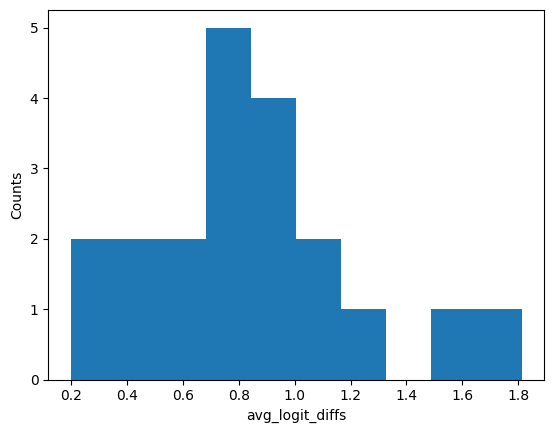

In [60]:
import matplotlib.pyplot as plt
avg_logit_diffs_rand_ablate = torch.as_tensor(avg_logit_diffs_rand_ablate)
plt.hist(avg_logit_diffs_rand_ablate.cpu())
plt.ylabel('Counts')
plt.xlabel('avg_logit_diffs')

In [61]:
# mean = np.mean(avg_logit_diffs_rand_ablate)
# variance = np.var(avg_logit_diffs_rand_ablate)
mean = torch.mean(avg_logit_diffs_rand_ablate)
std_dev = torch.std(avg_logit_diffs_rand_ablate)
print("Mean:", mean)
print("Standard Deviation:", std_dev.item())

Mean: tensor(0.8547)
Standard Deviation: 0.39780014753341675


Clearly, as our circuits have much higher scores than this distribution would say is likely, it is unlikely that these circuits are consistently obtaining these scores by random chance. Note that there are 2^(total number of heads) possible choices of node sets, and this does not even count the connections (given by SEQ_POS_TO_KEEP).

1/20 -> 5%

# Plot minimality scores

In [ ]:
# %%capture
# !pip install circuitsvis

Write a function that converts into this:

In [ ]:
# K_FOR_EACH_COMPONENT = {
#     (9, 9): set(),
#     (10, 0): {(9, 9)},
#     (9, 6): {(9, 9), (10, 0)},
#     (10, 7): {(11, 10)},
#     (11, 10): {(10, 7)},
#     (8, 10): {(7, 9), (8, 6), (7, 3)},
#     (7, 9): {(8, 10), (8, 6), (7, 3)},
#     (8, 6): {(7, 9), (8, 10), (7, 3)},
#     (7, 3): {(7, 9), (8, 10), (8, 6)},
#     (5, 5): {(5, 9), (6, 9), (5, 8)},
#     (5, 9): {(11, 10), (10, 7)},
#     (6, 9): {(5, 9), (5, 5), (5, 8)},
#     (5, 8): {(11, 10), (10, 7)},
#     (0, 1): {(0, 10), (3, 0)},
#     (0, 10): {(0, 1), (3, 0)},
#     (3, 0): {(0, 1), (0, 10)},
#     (4, 11): {(2, 2)},
#     (2, 2): {(4, 11)},
#     (11, 2): {(9, 9), (10, 0), (9, 6)},
#     (10, 6): {(9, 9), (10, 0), (9, 6), (11, 2)},
#     (10, 10): {(9, 9), (10, 0), (9, 6), (11, 2), (10, 6)},
#     (10, 2): {(9, 9), (10, 0), (9, 6), (11, 2), (10, 6), (10, 10)},
#     (9, 7): {(9, 9), (10, 0), (9, 6), (11, 2), (10, 6), (10, 10), (10, 2)},
#     (10, 1): {(9, 9), (10, 0), (9, 6), (11, 2), (10, 6), (10, 10), (10, 2), (9, 7)},
#     (11, 9): {(9, 9), (10, 0), (9, 6), (9, 0)},
#     (9, 0): {(9, 9), (10, 0), (9, 6), (11, 9)},
# }

In [ ]:
# from solutions import *

# def get_score(
# 	model: HookedTransformer,
# 	ioi_dataset: IOIDataset,
# 	abc_dataset: IOIDataset,
# 	K: Set[Tuple[int, int]],
# 	C: Dict[str, List[Tuple[int, int]]],
# ) -> float:
# 	'''
# 	Returns the value F(C \ K), where F is the logit diff, C is the
# 	core circuit, and K is the set of circuit components to remove.
# 	'''
# 	C_excl_K = {k: [head for head in v if head not in K] for k, v in C.items()}
# 	model = ioi_circuit_extraction.add_mean_ablation_hook(model, abc_dataset, C_excl_K, SEQ_POS_TO_KEEP)
# 	logits = model(ioi_dataset.toks)
# 	score = logits_to_ave_logit_diff_2(logits, ioi_dataset).item()

# 	return score

# def get_minimality_score(
# 		model: HookedTransformer,
# 		ioi_dataset: IOIDataset,
# 		abc_dataset: IOIDataset,
# 		v: Tuple[int, int],
# 		K: Set[Tuple[int, int]],
# 		C: Dict[str, List[Tuple[int, int]]] = CIRCUIT,
# 	) -> float:
# 		'''
# 		Returns the value | F(C \ K_union_v) - F(C | K) |, where F is
# 		the logit diff, C is the core circuit, K is the set of circuit
# 		components to remove, and v is a head (not in K).
# 		'''
# 		assert v not in K
# 		K_union_v = K | {v}
# 		C_excl_K_score = get_score(model, ioi_dataset, abc_dataset, K, C)
# 		C_excl_Kv_score = get_score(model, ioi_dataset, abc_dataset, K_union_v, C)

# 		return abs(C_excl_K_score - C_excl_Kv_score)

# def get_all_minimality_scores(
# 		model: HookedTransformer,
# 		ioi_dataset: IOIDataset = ioi_dataset,
# 		abc_dataset: IOIDataset = abc_dataset,
# 		k_for_each_component: Dict = K_FOR_EACH_COMPONENT
# 	) -> Dict[Tuple[int, int], float]:
# 		'''
# 		Returns dict of minimality scores for every head in the model (as
# 		a fraction of F(M), the logit diff of the full model).

# 		Warning - this resets all hooks at the end (including permanent).
# 		'''
# 		# Get full circuit score F(M), to divide minimality scores by
# 		model.reset_hooks(including_permanent=True)
# 		logits = model(ioi_dataset.toks)
# 		full_circuit_score = logits_to_ave_logit_diff_2(logits, ioi_dataset).item()

# 		# Get all minimality scores, using the `get_minimality_score` function
# 		minimality_scores = {}
# 		for v, K in tqdm(k_for_each_component.items()):
# 			score = get_minimality_score(model, ioi_dataset, abc_dataset, v, K)
# 			minimality_scores[v] = score / full_circuit_score

# 		model.reset_hooks(including_permanent=True)

# 		return minimality_scores

In [ ]:
# minimality_scores = get_all_minimality_scores(model)

In [ ]:
# def plot_minimal_set_results(minimality_scores: Dict[Tuple[int, int], float]):
#     '''
#     Plots the minimality results, in a way resembling figure 7 in the paper.

#     minimality_scores:
#         Dict with elements like (9, 9): minimality score for head 9.9 (as described
#         in section 4.2 of the paper)
#     '''

#     CIRCUIT_reversed = {head: k for k, v in CIRCUIT.items() for head in v}
#     colors = [CIRCUIT_reversed[head].capitalize() + " head" for head in minimality_scores.keys()]
#     color_sequence = [px.colors.qualitative.Dark2[i] for i in [0, 1, 2, 5, 3, 6]] + ["#BAEA84"]

#     bar(
#         list(minimality_scores.values()),
#         x=list(map(str, minimality_scores.keys())),
#         labels={"x": "Attention head", "y": "Change in logit diff", "color": "Head type"},
#         color=colors,
#         template="ggplot2",
#         color_discrete_sequence=color_sequence,
#         bargap=0.02,
#         yaxis_tickformat=".0%",
#         legend_title_text="",
#         title="Plot of minimality scores (as percentages of full model logit diff)",
#         width=800,
#         hovermode="x unified"
#     )

# plot_minimal_set_results(minimality_scores)